In [1]:
import os
import sys
import torch
import numpy as np
from timeit import default_timer as timer
from datetime import timedelta

BASE_DIR = os.path.dirname('./')
ROOT_DIR = os.path.dirname(BASE_DIR)
sys.path.append(ROOT_DIR)

import yaml

from lib.common.helpers.dataloader_helper import build_dataloader
from lib.common.helpers.model_helper import build_model
from lib.common.helpers.visualization_helper import visualization
from lib.common.helpers.print_helper import PrintHelper

In [2]:
mode = 'test' # test, eval, train
config = 'configs/kitti-multi.yaml'
from lib.monoDTR.printer import Printer as PrinterDTR
from lib.monoLSS.printer import Printer as PrinterLSS

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# load cfg
assert (os.path.exists(config))
cfg = yaml.load(open(config, 'r'), Loader=yaml.Loader)
  
#  build dataloader
dataset = build_dataloader(cfg['dataset'], mode)


printHelper = PrintHelper(dataset)


MonoDTR = PrinterDTR(cfg['MonoDTR'], build_model(cfg['MonoDTR']))
MonoLSS = PrinterLSS(cfg['MonoLSS'], build_model(cfg['MonoLSS']))


Using device: cuda


In [3]:
from lib.monoDTR.visualDet3D.networks.lib.ops.iou3d.iou3d import boxes_iou3d_gpu
from lib.common.helpers.detection_helper import detectionInfo

def compareAll(list1, list2):
    comparison_matrix = []

    for item1 in list1:
        row = []
        for item2 in list2:
            result = compare(item1, item2)
            row.append(result)
        comparison_matrix.append(row)
    
    positions = []

    for row_idx, row in enumerate(comparison_matrix):
        max_value = max(row)
        if max_value != 0:
            max_pos = row.index(max_value)

            if all(max_value >= comparison_matrix[row_idx][j] for j in range(len(row))) and \
               all(max_value >= comparison_matrix[i][max_pos] for i in range(len(comparison_matrix))):
                positions.append((row_idx, max_pos))

    return positions

def compare(item1, item2):
    info1 = detectionInfo(item1)
    info2 = detectionInfo(item2)
    bbox1 = np.array([info1.tx, info1.ty, info1.tz, info1.h, info1.w, info1.l, info1.rot_global]).astype(np.float32)
    bbox2 = np.array([info2.tx, info2.ty, info2.tz, info2.h, info2.w, info2.l, info2.rot_global]).astype(np.float32)


    return boxes_iou3d_gpu(torch.tensor(np.array([bbox1])).cuda(), torch.tensor(np.array([bbox2])).cuda()).detach().cpu().numpy()[0][0]

def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def average_angle(angle1, angle2, threshold=np.pi / 2):
    angle1 = normalize_angle(angle1)
    angle2 = normalize_angle(angle2)

    delta = np.abs(normalize_angle(angle2 - angle1))

    # A két AI lehet, hogy ellentétes irányba tippelik meg az objektumokat, 
    # ezért ellenőrznünk kell, hogy a különbség nagyobb-e 90 foknál.
    # Ilyenkor a MonoLSS a baseline és a MonoDTR-t tükrözzük.
    if delta > threshold: 
        angle2 = normalize_angle(angle2 + np.pi)

    cos1, sin1 = np.cos(angle1), np.sin(angle1)
    cos2, sin2 = np.cos(angle2), np.sin(angle2)

    avg_cos = (cos1 + cos2) / 2
    avg_sin = (sin1 + sin2) / 2

    avg_angle = np.arctan2(avg_sin, avg_cos)
    return avg_angle

def average_lists(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("A listák hossza nem egyezik.")

    averaged_list = []

    for row1, row2 in zip(list1, list2):
        if len(row1) != len(row2):
            raise ValueError("A sorok hossza nem egyezik.")
        
        averaged_row = []
        for val1, val2 in zip(row1, row2):
            if isinstance(val1, (float, np.float32)) and isinstance(val2, (float, np.float32)):
                averaged_row.append((val1 + val2) / 2)
            
            else:
                averaged_row.append(val1)
        
        rotation_y1 = row1[14]
        rotation_y2 = row2[14]
        
        avg_rotation_y = average_angle(rotation_y1, rotation_y2)

        averaged_row[14] = avg_rotation_y
        
        averaged_list.append(averaged_row)

    return averaged_list

In [64]:
idx = 0


37


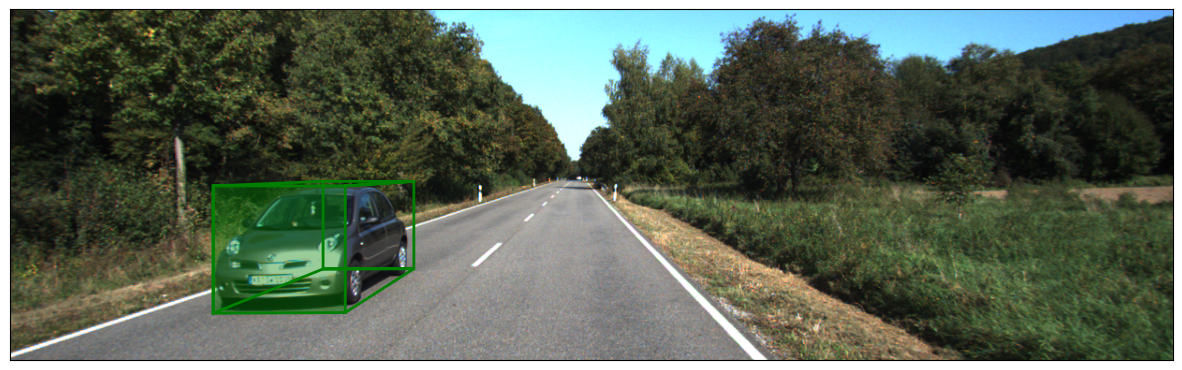

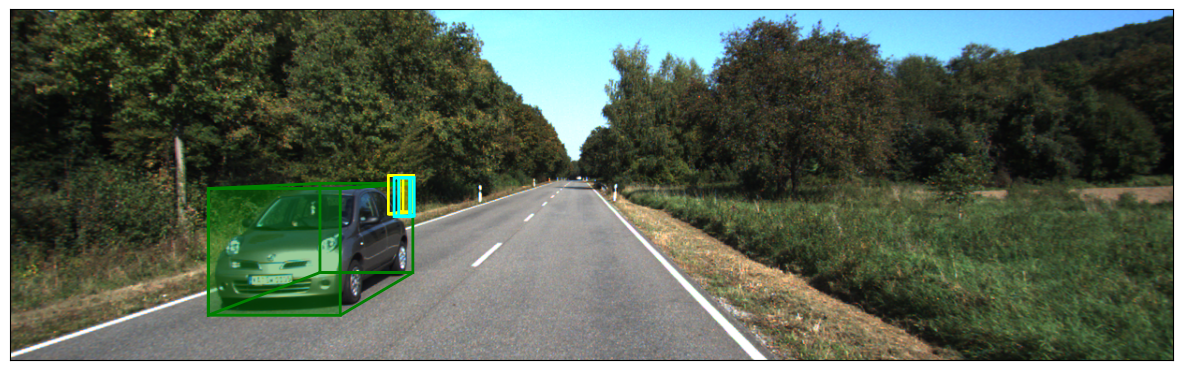

közös: 


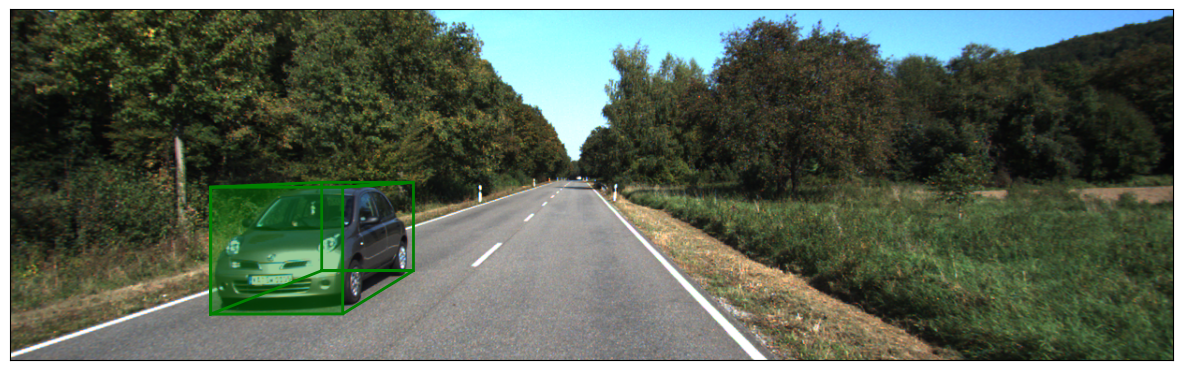

MonoLSS: 


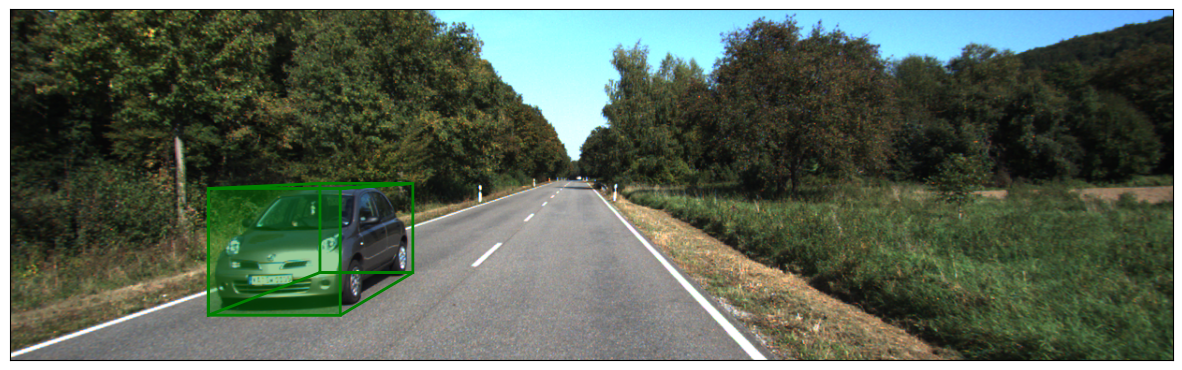

MonoDTR: 


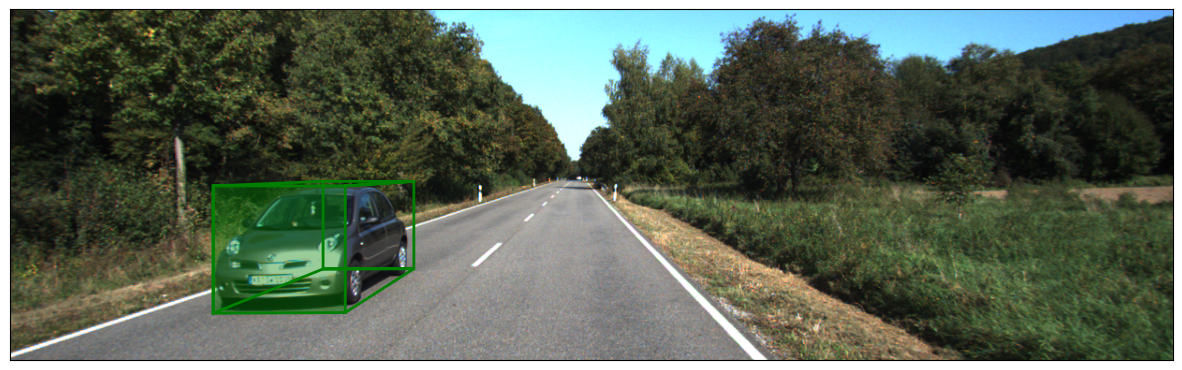

In [103]:
print(idx)

for x in range(1):
    img, calibs = printHelper.getPrintables(idx)
    
    torch.cuda.synchronize() # Wait for all kernels in all streams on a CUDA device to complete.
    start_time = timer()

    predsDTR = MonoDTR.print(img, calibs, 0)
    predsLSS = MonoLSS.print(img, calibs, 0.05)

    torch.cuda.synchronize() # Wait for all kernels in all streams on a CUDA device to complete.
    end_time = timer()
    #print(timedelta(seconds=end_time - start_time))
    
    same = compareAll(predsDTR,predsLSS)
    resultsLSS = []
    resultsDTR = []
    for dtr_idx, lss_idx in same:
        resultsLSS.append(predsLSS[lss_idx])
        resultsDTR.append(predsDTR[dtr_idx])

    result = average_lists(resultsLSS, resultsDTR)

    print('közös: ')
    #print(result)
    #print(resultsLSS)
    #print(resultsDTR)
    visualization(img, calibs, result, True, False, False)

    print('MonoLSS: ')
    #print(resultsLSS)
    #visualization(img, calibs, predsLSS, True, False, False)
    visualization(img, calibs, resultsLSS, True, False, False)

    print('MonoDTR: ')
    #print(resultsDTR)
    #visualization(img, calibs, predsDTR, True, False, False)
    visualization(img, calibs, resultsDTR, True, False, False)

    idx = idx +1